In [ ]:

# ===============================================================
# Notebook: K-Means Clustering — Credit Card Customers
# Preprocesamiento, análisis de clusters, entrenamiento y exportación
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import joblib

# Cargar dataset
df = pd.read_csv("../data/CC GENERAL.csv")
df.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [2]:
# ===========================
# Limpieza de datos
# ===========================

# Eliminar columnas irrelevantes
# 'CUST_ID' no aporta al clustering
df.drop(columns=["CUST_ID"], inplace=True)

# Reemplazar NaN por la media
df.fillna(df.mean(), inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [3]:
# ===========================
# Escalar datos numéricos
# ===========================

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Guardar scaler
joblib.dump(scaler, "../modelos/scaler_cc.pkl")

df_scaled[:5]


array([[-7.31989366e-01, -2.49434481e-01, -4.24899735e-01,
        -3.56934022e-01, -3.49078819e-01, -4.66785554e-01,
        -8.06490346e-01, -6.78660808e-01, -7.07313165e-01,
        -6.75348858e-01, -4.76069817e-01, -5.11333250e-01,
        -9.60433344e-01, -5.28978791e-01, -3.10967549e-01,
        -5.25550971e-01,  3.60679544e-01],
       [ 7.86960853e-01,  1.34324671e-01, -4.69551882e-01,
        -3.56934022e-01, -4.54576230e-01,  2.60560451e+00,
        -1.22175806e+00, -6.78660808e-01, -9.16995191e-01,
         5.73962722e-01,  1.10073852e-01, -5.91795877e-01,
         6.88639034e-01,  8.18642127e-01,  8.93102090e-02,
         2.34226897e-01,  3.60679544e-01],
       [ 4.47135132e-01,  5.18083823e-01, -1.07668230e-01,
         1.08888513e-01, -4.54576230e-01, -4.66785554e-01,
         1.26984323e+00,  2.67345108e+00, -9.16995191e-01,
        -6.75348858e-01, -4.76069817e-01, -1.09020117e-01,
         8.26061732e-01, -3.83804738e-01, -1.01663181e-01,
        -5.25550971e-01,  3.6

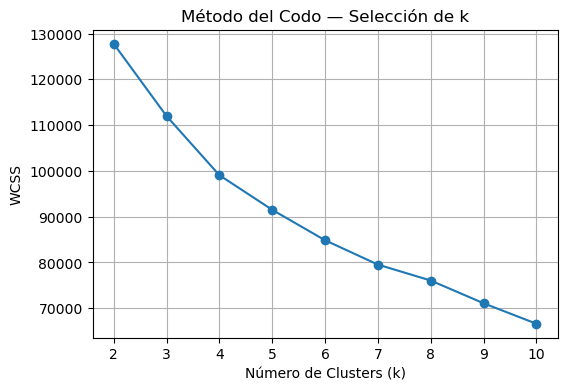

In [4]:
# ==============================
# Método del Codo
# ==============================

wcss = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, wcss, marker="o")
plt.title("Método del Codo — Selección de k")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


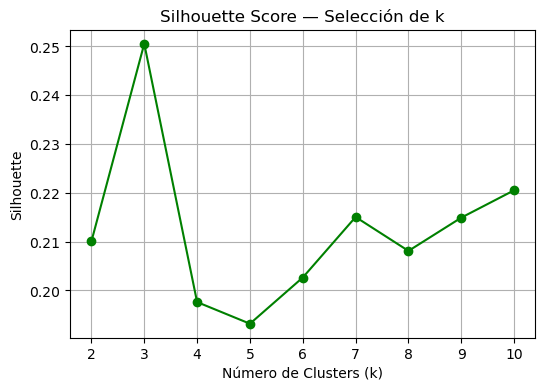

In [5]:
# ===========================
# Silhouette Score
# ===========================

sil_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    sil = silhouette_score(df_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, marker="o", color="green")
plt.title("Silhouette Score — Selección de k")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


In [6]:
# ===========================
# Entrenar modelo final
# ===========================

k_final = 4  # Valor recomendado para este dataset

kmeans_model = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_model.fit(df_scaled)

# Guardar modelo
joblib.dump(kmeans_model, "../modelos/kmeans_model.pkl")

kmeans_model


KMeans(n_clusters=4, n_init=10, random_state=42)

In [7]:
# ===========================
# Agregar labels al dataset
# ===========================

df_clusters = df.copy()
df_clusters["cluster"] = kmeans_model.labels_

df_clusters.head()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,3
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,3
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,3


In [8]:
# ===========================
# Promedio por cluster
# ===========================

cluster_summary = df_clusters.groupby("cluster").mean()
cluster_summary


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,894.907458,0.934734,1236.178934,593.974874,642.478274,210.570626,0.885165,0.297070,0.711842,0.042573,0.790021,22.091773,4213.207678,1332.194205,650.167072,0.269258,11.594595
1,3551.153761,0.986879,7681.620098,5095.878826,2587.208264,653.638891,0.946418,0.739031,0.788060,0.071290,2.085575,89.359413,9696.943765,7288.739497,1976.815179,0.286707,11.951100
2,4602.462714,0.968415,501.896219,320.373681,181.607404,4520.724309,0.287731,0.138934,0.185516,0.484526,14.284641,7.661102,7546.957050,3481.145990,2008.251157,0.034859,11.387312
3,1011.751528,0.789871,269.973466,209.853863,60.386625,595.759339,0.170146,0.086281,0.080578,0.114833,2.125503,2.903421,3277.703165,974.505090,586.301239,0.078001,11.446429


In [9]:
import joblib

joblib.dump(df.columns.tolist(), "../modelos/cc_columns.pkl")


['../modelos/cc_columns.pkl']